### Preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd drive/My\ Drive/Colab\ Notebooks/Face_Recognition

/content/drive/My Drive/Colab Notebooks/Face_Recognition


In [4]:
%ls

CroppedYale/  CroppedYale_jpg/  data/  dev/  README.md  Yale_Test/


In [4]:
%%capture
!unzip data/CroppedYale.zip

In [5]:
%%capture
!python dev/pgm_to_jpg.py

### Trials

In [5]:
#all required packages
import numpy as np

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from torchsummary import summary

"""
!pip install einops
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary
"""

'\n!pip install einops\nfrom einops import rearrange, reduce, repeat\nfrom einops.layers.torch import Rearrange, Reduce\nfrom torchsummary import summary\n'

In [6]:
%pwd #Face_Recognition

'/content/drive/My Drive/Colab Notebooks/Face_Recognition'

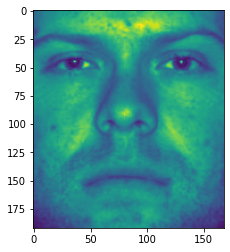

In [7]:
img = Image.open('CroppedYale_jpg/yaleB01/yaleB01_P00A+000E+0.jpg')
#/content/drive/MyDrive/Colab Notebooks/Face_Recognition/CroppedYale/yaleB01/yaleB01_P00A+000E+00.pgm
fig = plt.figure()
plt.imshow(img)


In [8]:
# resize to imagenet size -> maybe Create a function for this!!
transform = Compose([Resize((224, 224)), ToTensor()])
x = transform(img)# add batch dim
x = x.unsqueeze(0)
x.shape

torch.Size([1, 1, 224, 224])

In [40]:
test_x = test_x.unsqueeze(0)
test_x.shape

torch.Size([1, 3, 224, 224])

In [11]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768, img_size: int = 224):
        super().__init__()
        self.patch_size = patch_size #16
        self.class_token = torch.randn(1,1,emb_size) #image representation
        self.pos_embedding = torch.randn((img_size // patch_size)**2 + 1, emb_size) #positional embedding of patch

        self.projection = nn.Sequential(
            # Convolution Layer to each patch
            nn.Conv2d(in_channels=in_channels, out_channels=emb_size, kernel_size=patch_size, stride=patch_size)
        )
                
    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)

        #Flatten images after Convolution
        x = torch.flatten(x, start_dim=2, end_dim=3)
        x = torch.transpose(x, 1, 2)

        batch,_,_=x.shape # batch size
        #print(device)
        # Concatenate Class Tensor to Projected Patches
        class_tensor = self.class_token.repeat(batch,1,1)
        #class_tensor.to(device='cuda') this so far doesnt work
        #x.to(device='cuda')
        x = torch.cat([class_tensor, x], dim=1)#.to(device='cuda')

        # Add Positional Embedding to Projected Patches
        x += self.pos_embedding

        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads

        self.qs = nn.Linear(emb_size, emb_size)
        self.ks = nn.Linear(emb_size, emb_size)
        self.vs = nn.Linear(emb_size, emb_size)

        self.A_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        b,n,_ = x.shape #b: batch_size || n: input_size
        d = int(self.emb_size / self.num_heads) # d: sequence_length
        #print(b)
        # Create 'num_heads' subsets of Query, Key and Values with shape-> (BATCH_SIZE:b, NUM_HEADS:h, SEQUENCE_LENGTH:qdk, EMBEDDING_SIZE:d )
        Q = self.qs(x).reshape((b, self.num_heads, n, d))
        K = self.ks(x).reshape((b, self.num_heads, n, d))
        V = self.vs(x).reshape((b, self.num_heads, n, d))

        # Basic Attention
        attention = torch.einsum('bhqd, bhkd -> bhqk', Q, K) / np.sqrt(Q.shape[-1]) # Matrix product between Q and K and Scaling

        if mask is not None:
            attention = attention.masked_fill(mask[None], -np.inf) #masked_fill -> torch function

        attention = torch.softmax(attention, dim=3) 
        attention = self.A_drop(attention) #attention vector

        # output processing
        output = torch.einsum('bhal, bhlv -> bhav ', attention, V) #use attention to scale the values
        output = torch.transpose(output, 1, 2)
        output= torch.flatten(output, start_dim=2, end_dim=3)
        output = self.projection(output)
        
        return output


class Residuals(nn.Module):
    def __init__(self, ffnn):
        super().__init__()
        self.ffnn = ffnn #Feed Forward Neural Network ???
        
    def forward(self, x, **kwargs):
        res = x
        x = self.ffnn(x, **kwargs)
        x += res
        return x

# The feed foeward network with 2 linear layers with a GELU nonlinearity
class MLP(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, dropout: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(expansion * emb_size, emb_size),
        )


class Encoder(nn.Sequential):
    def __init__(self, emb_size: int = 768, dropout: float = 0., f_expansion: int = 4, f_dropout: float = 0., ** kwargs):
        super().__init__(
            Residuals(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(dropout)
            )),
            Residuals(nn.Sequential(
                nn.LayerNorm(emb_size),
                MLP(emb_size, expansion=f_expansion, dropout=f_dropout),
                nn.Dropout(dropout)
            )
            ))

class TransformerEncoder(nn.Sequential):
    def __init__(self, n_blocks: int = 8, **kwargs):
        super().__init__(*[Encoder(**kwargs) for _ in range(n_blocks)])

class ClassLayer(nn.Module):
    def __init__(self, emb_size: int = 768, n_classes: int = 100):
        super().__init__()
        self.class_head = nn.Sequential(
            nn.LayerNorm(emb_size), 
            nn.Linear(emb_size, n_classes))
    def forward(self, x: Tensor) -> Tensor:
        mean_x = torch.mean(x, dim = 0) #mean over the sequence
        return self.class_head(mean_x)

class ViT(nn.Sequential):
    def __init__(self,     
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 224,
                depth: int = 6,
                n_classes: int = 100,
                device = "cuda",
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassLayer(emb_size, n_classes)
        )

In [25]:
model = ViT(n_classes=2)

In [42]:
output = model(test_x)

In [44]:
output

tensor([[ 5.9908e-01,  4.6159e-01],
        [ 3.0884e-01, -7.0720e-02],
        [ 1.7438e+00, -1.3725e-01],
        [-2.7131e-01,  8.5279e-01],
        [ 4.0349e-01,  1.1656e-01],
        [ 1.7368e-01,  3.6661e-01],
        [ 4.1547e-01,  4.0555e-02],
        [ 5.3568e-01, -1.0985e+00],
        [ 3.4940e-01,  3.8294e-01],
        [-6.5008e-01,  2.0460e-01],
        [ 4.9933e-01,  5.8404e-01],
        [-7.4112e-01,  4.9853e-01],
        [ 3.7528e-01, -2.8790e-01],
        [ 4.5900e-02,  3.7219e-01],
        [-7.5940e-01, -7.0424e-02],
        [-2.0398e-02,  3.6755e-01],
        [ 3.1643e-01,  1.9691e-01],
        [ 6.7256e-02, -4.5423e-01],
        [ 6.8008e-01,  2.9843e-01],
        [ 4.1257e-01,  6.9321e-02],
        [-8.4047e-02, -1.5408e-01],
        [ 4.4902e-01,  4.4304e-02],
        [ 8.7229e-01,  2.8493e-01],
        [ 8.4087e-01, -1.0501e-01],
        [ 5.5276e-01, -6.7251e-01],
        [-6.3062e-01,  7.0430e-01],
        [ 4.1783e-01, -4.7421e-01],
        [ 4.7742e-01, -2.623

In [39]:
i = 0
for image in dataset_test:
  print(image[0].shape)
  print(image[1])

  i += 1
  if i>2: break

torch.Size([3, 224, 224])
0
torch.Size([3, 224, 224])
0
torch.Size([3, 224, 224])
0


In [12]:
summary(ViT(n_classes=2), (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
    PatchEmbedding-2             [-1, 197, 768]               0
         LayerNorm-3             [-1, 197, 768]           1,536
            Linear-4             [-1, 197, 768]         590,592
            Linear-5             [-1, 197, 768]         590,592
            Linear-6             [-1, 197, 768]         590,592
           Dropout-7          [-1, 8, 197, 197]               0
            Linear-8             [-1, 197, 768]         590,592
MultiHeadAttention-9             [-1, 197, 768]               0
          Dropout-10             [-1, 197, 768]               0
        Residuals-11             [-1, 197, 768]               0
        LayerNorm-12             [-1, 197, 768]           1,536
           Linear-13            [-1, 197, 3072]       2,362,368
             GELU-14            [-1, 19

### TRAIN

In [13]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [22]:
torch.randn(8)

tensor([ 1.4198,  1.5016,  0.1703, -0.4827, -0.6781,  0.8337,  0.6723, -0.1643,
         1.0157, -0.3099])

In [23]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        print(f'data: {data.shape}')
        print(f'target: {target}')
        print(f'target_s: {target.shape}')
        optimizer.zero_grad()
        output = model(data)
        print(f'output: {output.shape}')
        hola = torch.randn(8)
        loss = F.nll_loss(hola, target)
        return(loss)
        break
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if dry_run:
                break

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


# TODO train_loader/test_loader in main()

def main(data_set):

    # Training Parameters
    """
    parser = argparse.ArgumentParser(description='ViT Trainer')
    parser.add_argument('--batch_size', type=int, default=32, metavar='N',
                        help='input batch size for training (default: 32)')
    parser.add_argument('--test_batch_size', type=int, default=100, metavar='N',
                        help='input batch size for testing (default: 100)')
    parser.add_argument('--epochs', type=int, default=14, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    
    args = parser.parse_args()
    """
    batch_size = 8
    test_batch_size=100
    epochs=14
    lr=1.0
    gamma=0.7
    n_faces=2
    log_interval = 5
    dry_run = False

    torch.manual_seed(1)

    use_cuda = torch.cuda.is_available() #set runtime to GPU for 'True'
    device = torch.device("cuda" if use_cuda else "cpu")

    train_kwargs = {'batch_size': batch_size}
    test_kwargs = {'batch_size': test_batch_size}

    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform = Compose([Resize((224, 224)), ToTensor()])

    train_dataset = data_set
    test_dataset = 0
    
    train_loader = torch.utils.data.DataLoader(train_dataset,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(test_dataset, **test_kwargs)

    model = ViT(n_classes=n_faces, device=device).to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()

    torch.save(model.state_dict(), "trained_ViT.pt")


In [15]:
import torch
from torchvision.datasets import ImageFolder

transform = Compose([Resize((224, 224)), ToTensor()])
dataset_test = ImageFolder('Yale_Test', transform=transform)

In [24]:
main(dataset_test)

data: torch.Size([8, 3, 224, 224])
target: tensor([0, 0, 0, 0, 0, 0, 0, 0])
target_s: torch.Size([8])
output: torch.Size([197, 2])


ValueError: ignored